In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Set parameters
num = 100
iterations = 1000  # Number of times to repeat the simulation

# Store coefficients
coeffs_q1 = []
coeffs_q2 = []

for _ in range(iterations):
    # Generate synthetic data
    difficulty = np.random.uniform(0, 1, (num,))
    speed = np.maximum(np.random.normal(15, 5, (num, )) - difficulty * 10, 0)
    accident = np.minimum(np.maximum(0.03 * speed + 0.4 * difficulty + np.random.normal(0, 0.3, (num,)), 0), 1)
    
    # Question 1: Regress speed (Y) on difficulty (X)
    model_q1 = LinearRegression().fit(difficulty.reshape(-1, 1), speed)
    coeffs_q1.append(model_q1.coef_[0])

    # Question 2: Regress speed (Y) on difficulty (X) and accident (Z)
    X_q2 = np.column_stack((difficulty, accident))
    model_q2 = LinearRegression().fit(X_q2, speed)
    coeffs_q2.append(model_q2.coef_[0])  # Coefficient for difficulty

# Compute average coefficients
avg_coeff_q1 = np.mean(coeffs_q1)
avg_coeff_q2 = np.mean(coeffs_q2)

print("Average coefficient of X when predicting Y (Q1):", avg_coeff_q1)
print("Average coefficient of X when predicting Y with Z included (Q2):", avg_coeff_q2)


Average coefficient of X when predicting Y (Q1): -9.64750130348507
Average coefficient of X when predicting Y with Z included (Q2): -10.280698924572185


🚴 Causal Inference Analysis: Biking Accident Example

📊 Sample Data Overview:
        difficulty        speed     accident
count  1000.000000  1000.000000  1000.000000
mean      0.490257    10.695531     0.518749
std       0.292137     5.624793     0.289253
min       0.004632     0.000000     0.000000
25%       0.235973     6.879799     0.312447
50%       0.496807    10.674237     0.522351
75%       0.744320    14.536353     0.740837
max       0.999718    27.320370     1.000000


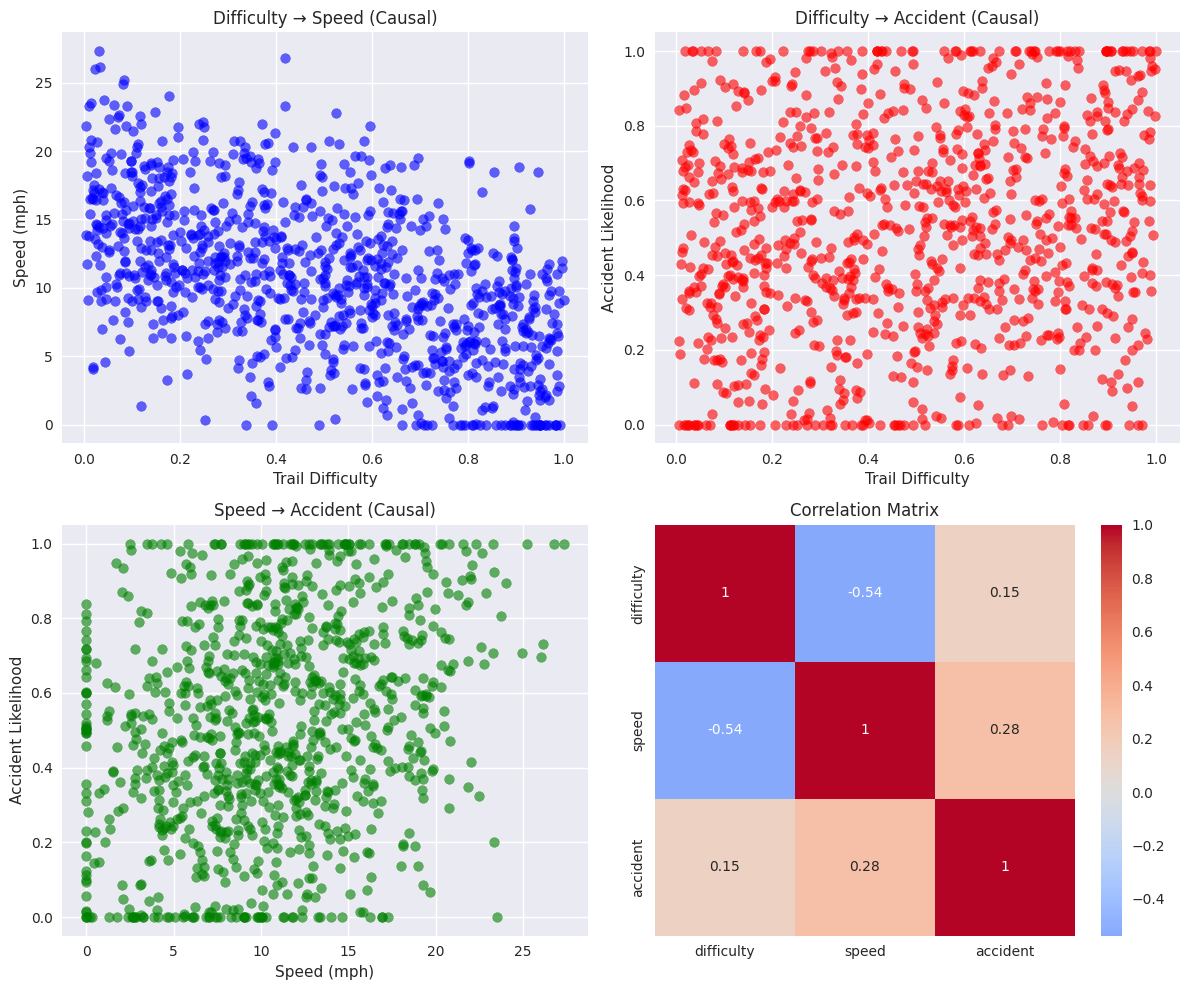


🔍 True coefficient of difficulty on speed: -10
   (from data generation: speed = normal(15,5) - difficulty * 10)


In [2]:
# Causal Inference Analysis: Biking Accident Example
# Questions about regression coefficients and collider bias

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style for better plots
plt.style.use('seaborn-v0_8')
np.random.seed(42)  # For reproducibility

print("🚴 Causal Inference Analysis: Biking Accident Example")
print("=" * 60)

# %% [markdown]
## Problem Setup
# 
# **Variables:**
# - X = difficulty (trail difficulty, 0-1 scale)
# - Y = speed (miles per hour) 
# - Z = accident (likelihood of accident, 0-1 scale)
# 
# **Causal Structure:**
# - X → Y (negative): Difficult trails cause people to go slower
# - X → Z (positive): Difficult trails increase accident risk
# - Y → Z (positive): Higher speed increases accident risk
# 
# **Data Generation Process:**
# ```python
# difficulty = np.random.uniform(0, 1, (num,))
# speed = np.maximum(np.random.normal(15, 5, (num,)) - difficulty * 10, 0)
# accident = np.minimum(np.maximum(0.03 * speed + 0.4 * difficulty + np.random.normal(0, 0.3, (num,)), 0), 1)
# ```

# %% 
# Data generation function
def generate_biking_data(num=100, seed=None):
    """Generate biking data according to the specified process"""
    if seed is not None:
        np.random.seed(seed)
    
    # X: Trail difficulty (0-1)
    difficulty = np.random.uniform(0, 1, (num,))
    
    # Y: Speed (mph) - decreases with difficulty
    speed = np.maximum(np.random.normal(15, 5, (num,)) - difficulty * 10, 0)
    
    # Z: Accident likelihood (0-1) - increases with both speed and difficulty
    accident = np.minimum(
        np.maximum(0.03 * speed + 0.4 * difficulty + np.random.normal(0, 0.3, (num,)), 0), 
        1
    )
    
    return pd.DataFrame({
        'difficulty': difficulty, 
        'speed': speed, 
        'accident': accident
    })

# Generate sample data to visualize relationships
sample_df = generate_biking_data(1000, seed=42)

print("\n📊 Sample Data Overview:")
print(sample_df.describe())

# %% 
# Visualize the relationships
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Difficulty vs Speed
axes[0,0].scatter(sample_df['difficulty'], sample_df['speed'], alpha=0.6, color='blue')
axes[0,0].set_xlabel('Trail Difficulty')
axes[0,0].set_ylabel('Speed (mph)')
axes[0,0].set_title('Difficulty → Speed (Causal)')

# Difficulty vs Accident
axes[0,1].scatter(sample_df['difficulty'], sample_df['accident'], alpha=0.6, color='red')
axes[0,1].set_xlabel('Trail Difficulty') 
axes[0,1].set_ylabel('Accident Likelihood')
axes[0,1].set_title('Difficulty → Accident (Causal)')

# Speed vs Accident
axes[1,0].scatter(sample_df['speed'], sample_df['accident'], alpha=0.6, color='green')
axes[1,0].set_xlabel('Speed (mph)')
axes[1,0].set_ylabel('Accident Likelihood')
axes[1,0].set_title('Speed → Accident (Causal)')

# Correlation matrix
corr_matrix = sample_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
axes[1,1].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

print(f"\n🔍 True coefficient of difficulty on speed: -10")
print(f"   (from data generation: speed = normal(15,5) - difficulty * 10)")



📋 QUESTION 1: Regression of Speed on Difficulty Only
🔄 Running 1000 regression experiments...

📈 Results for Question 1:
   Average coefficient: -9.740
   Standard deviation: 1.662
   True coefficient: -10.000

🎯 Answer choices and distances from average:
   A) -10.140 (distance: 0.400)
   B) -9.243 (distance: 0.497)
   C) -9.661 (distance: 0.079)
   D) -8.927 (distance: 0.813)

✅ Best answer for Question 1: C) -9.661


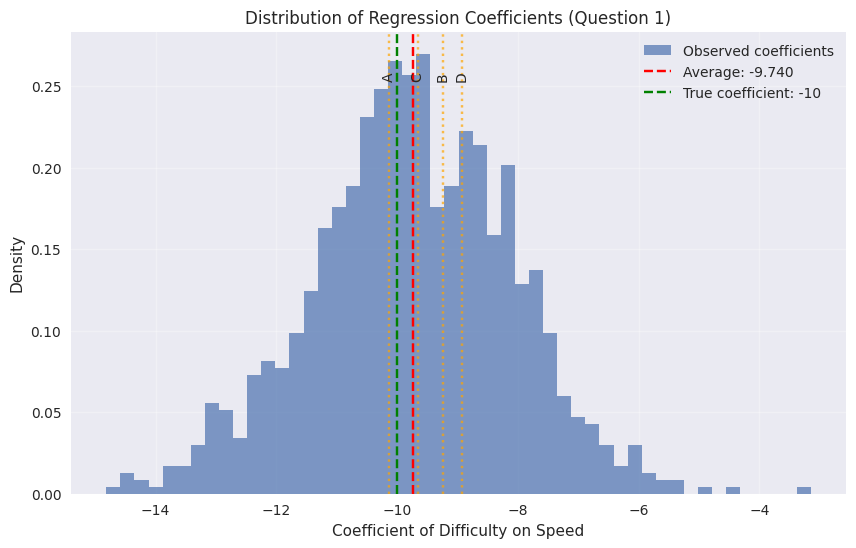

In [3]:
# %%
# QUESTION 1: Use X to predict Y many times via regression
# Find which coefficient is closest to the average

print("\n" + "="*60)
print("📋 QUESTION 1: Regression of Speed on Difficulty Only")
print("="*60)

def run_multiple_regressions_x_only(n_experiments=1000, sample_size=100):
    """Run many regressions of Y on X only"""
    coefficients = []
    
    for i in range(n_experiments):
        # Generate new data for each experiment
        df = generate_biking_data(sample_size, seed=i)
        
        # Regression: speed ~ difficulty
        X = df[['difficulty']]
        y = df['speed']
        
        model = LinearRegression()
        model.fit(X, y)
        
        coefficients.append(model.coef_[0])
    
    return np.array(coefficients)

# Run the experiment
print("🔄 Running 1000 regression experiments...")
coefficients_q1 = run_multiple_regressions_x_only(1000, 100)

print(f"\n📈 Results for Question 1:")
print(f"   Average coefficient: {np.mean(coefficients_q1):.3f}")
print(f"   Standard deviation: {np.std(coefficients_q1):.3f}")
print(f"   True coefficient: -10.000")

# Answer choices
answer_choices_q1 = {
    'A': -10.14,
    'B': -9.243, 
    'C': -9.661,
    'D': -8.927
}

print(f"\n🎯 Answer choices and distances from average:")
avg_coef_q1 = np.mean(coefficients_q1)
for choice, value in answer_choices_q1.items():
    distance = abs(value - avg_coef_q1)
    print(f"   {choice}) {value:6.3f} (distance: {distance:.3f})")

best_choice_q1 = min(answer_choices_q1.items(), key=lambda x: abs(x[1] - avg_coef_q1))
print(f"\n✅ Best answer for Question 1: {best_choice_q1[0]}) {best_choice_q1[1]}")

# Plot distribution of coefficients
plt.figure(figsize=(10, 6))
plt.hist(coefficients_q1, bins=50, alpha=0.7, density=True, label='Observed coefficients')
plt.axvline(np.mean(coefficients_q1), color='red', linestyle='--', 
            label=f'Average: {np.mean(coefficients_q1):.3f}')
plt.axvline(-10, color='green', linestyle='--', label='True coefficient: -10')

# Mark answer choices
for choice, value in answer_choices_q1.items():
    plt.axvline(value, color='orange', alpha=0.7, linestyle=':')
    plt.text(value, plt.ylim()[1]*0.9, choice, rotation=90, ha='center')

plt.xlabel('Coefficient of Difficulty on Speed')
plt.ylabel('Density')
plt.title('Distribution of Regression Coefficients (Question 1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


📋 QUESTION 2: Regression of Speed on Difficulty AND Accident
⚠️  WARNING: This includes a COLLIDER (accident is caused by both speed and difficulty)
   This will introduce bias in the coefficient estimate!
🔄 Running 1000 regression experiments with collider...

📈 Results for Question 2:
   Average coefficient of difficulty: -10.399
   Average coefficient of accident: 7.033
   Standard deviation (difficulty): 1.501

🎯 Answer choices and distances from average:
   A) -10.330 (distance: 0.069)
   B) -9.821 (distance: 0.578)
   C) -10.850 (distance: 0.451)
   D) -11.230 (distance: 0.831)

✅ Best answer for Question 2: A) -10.33

🔄 Comparison:
   Q1 (no collider): -9.740
   Q2 (with collider): -10.399
   Bias introduced: -0.660


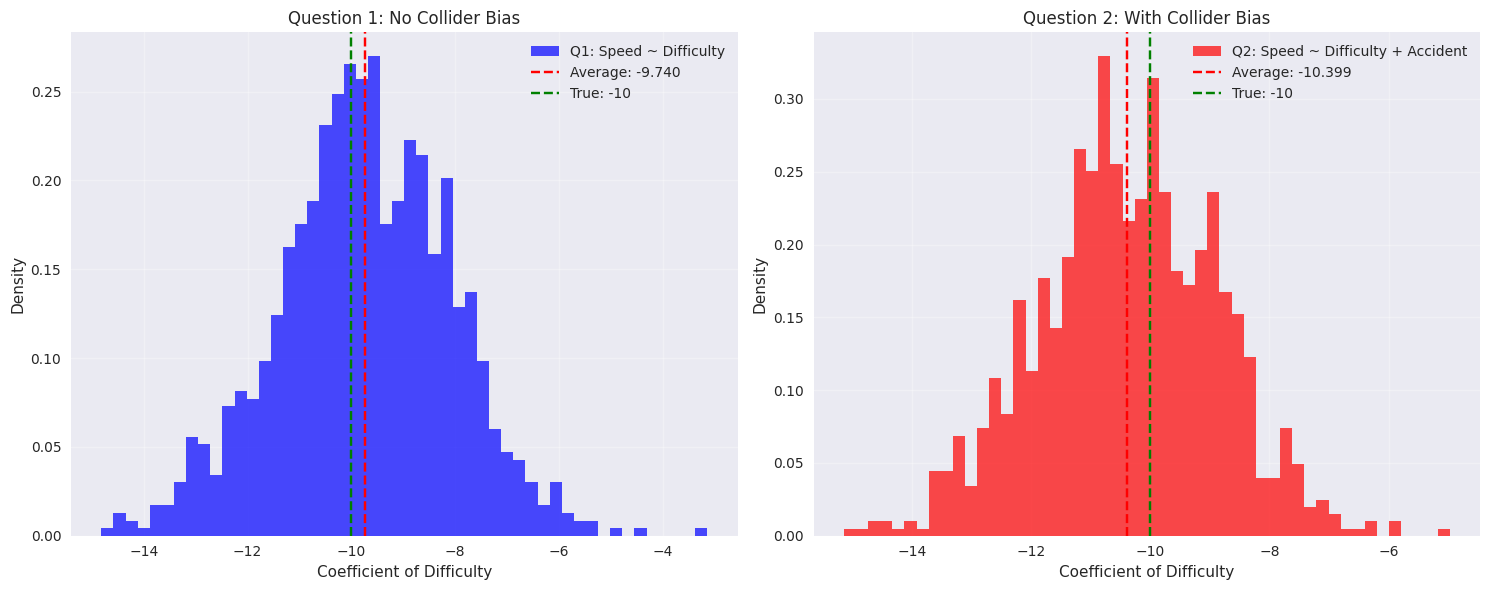

In [4]:
# %%
# QUESTION 2: Use X and Z to predict Y many times
# This introduces collider bias!

print("\n" + "="*60)
print("📋 QUESTION 2: Regression of Speed on Difficulty AND Accident")
print("="*60)
print("⚠️  WARNING: This includes a COLLIDER (accident is caused by both speed and difficulty)")
print("   This will introduce bias in the coefficient estimate!")

def run_multiple_regressions_with_collider(n_experiments=1000, sample_size=100):
    """Run many regressions of Y on X and Z (collider bias)"""
    coefficients_x = []
    coefficients_z = []
    
    for i in range(n_experiments):
        # Generate new data for each experiment
        df = generate_biking_data(sample_size, seed=i)
        
        # Regression: speed ~ difficulty + accident
        X = df[['difficulty', 'accident']]
        y = df['speed']
        
        model = LinearRegression()
        model.fit(X, y)
        
        coefficients_x.append(model.coef_[0])  # Coefficient for difficulty
        coefficients_z.append(model.coef_[1])  # Coefficient for accident
    
    return np.array(coefficients_x), np.array(coefficients_z)

# Run the experiment
print("🔄 Running 1000 regression experiments with collider...")
coefficients_x_q2, coefficients_z_q2 = run_multiple_regressions_with_collider(1000, 100)

print(f"\n📈 Results for Question 2:")
print(f"   Average coefficient of difficulty: {np.mean(coefficients_x_q2):.3f}")
print(f"   Average coefficient of accident: {np.mean(coefficients_z_q2):.3f}")
print(f"   Standard deviation (difficulty): {np.std(coefficients_x_q2):.3f}")

# Answer choices for Question 2
answer_choices_q2 = {
    'A': -10.33,
    'B': -9.821,
    'C': -10.85,
    'D': -11.23
}

print(f"\n🎯 Answer choices and distances from average:")
avg_coef_q2 = np.mean(coefficients_x_q2)
for choice, value in answer_choices_q2.items():
    distance = abs(value - avg_coef_q2)
    print(f"   {choice}) {value:6.3f} (distance: {distance:.3f})")

best_choice_q2 = min(answer_choices_q2.items(), key=lambda x: abs(x[1] - avg_coef_q2))
print(f"\n✅ Best answer for Question 2: {best_choice_q2[0]}) {best_choice_q2[1]}")

# Compare the two questions
print(f"\n🔄 Comparison:")
print(f"   Q1 (no collider): {np.mean(coefficients_q1):.3f}")
print(f"   Q2 (with collider): {np.mean(coefficients_x_q2):.3f}")
print(f"   Bias introduced: {np.mean(coefficients_x_q2) - np.mean(coefficients_q1):.3f}")

# %%
# Visualize the bias
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Question 1 distribution
ax1.hist(coefficients_q1, bins=50, alpha=0.7, density=True, color='blue', label='Q1: Speed ~ Difficulty')
ax1.axvline(np.mean(coefficients_q1), color='red', linestyle='--', 
            label=f'Average: {np.mean(coefficients_q1):.3f}')
ax1.axvline(-10, color='green', linestyle='--', label='True: -10')
ax1.set_xlabel('Coefficient of Difficulty')
ax1.set_ylabel('Density')
ax1.set_title('Question 1: No Collider Bias')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Question 2 distribution
ax2.hist(coefficients_x_q2, bins=50, alpha=0.7, density=True, color='red', label='Q2: Speed ~ Difficulty + Accident')
ax2.axvline(np.mean(coefficients_x_q2), color='red', linestyle='--', 
            label=f'Average: {np.mean(coefficients_x_q2):.3f}')
ax2.axvline(-10, color='green', linestyle='--', label='True: -10')
ax2.set_xlabel('Coefficient of Difficulty')
ax2.set_ylabel('Density')
ax2.set_title('Question 2: With Collider Bias')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [5]:
# %%
# Demonstrate why collider bias occurs
print("\n" + "="*60)
print("🧠 UNDERSTANDING COLLIDER BIAS")
print("="*60)

# Generate one sample to analyze
demo_df = generate_biking_data(1000, seed=123)

print("Causal structure:")
print("  Difficulty → Speed → Accident")
print("  Difficulty → Accident")
print()
print("When we control for Accident (a collider), we create spurious correlation!")

# Show partial correlations
from scipy.stats import pearsonr

# Unconditional correlation
corr_unconditional, _ = pearsonr(demo_df['difficulty'], demo_df['speed'])
print(f"\nUnconditional correlation (Difficulty, Speed): {corr_unconditional:.3f}")

# Conditional correlation (controlling for accident levels)
accident_levels = [
    (0.0, 0.2, "Low accident risk"),
    (0.2, 0.4, "Medium accident risk"), 
    (0.4, 0.6, "High accident risk"),
    (0.6, 1.0, "Very high accident risk")
]

print("\nConditional correlations (controlling for accident levels):")
for low, high, label in accident_levels:
    mask = (demo_df['accident'] >= low) & (demo_df['accident'] < high)
    subset = demo_df[mask]
    if len(subset) > 10:  # Only if we have enough data
        corr_conditional, _ = pearsonr(subset['difficulty'], subset['speed'])
        print(f"  {label:20s}: {corr_conditional:.3f} (n={len(subset)})")

print("\n💡 Key Insight:")
print("   Controlling for a collider (accident) distorts the true relationship!")
print("   This is why Question 2 gives a biased coefficient estimate.")

# %%
# Final summary
print("\n" + "="*80)
print("📋 FINAL ANSWERS")
print("="*80)

print(f"Question 1 - Use X to predict Y:")
print(f"  Best answer: {best_choice_q1[0]}) {best_choice_q1[1]}")
print(f"  Reasoning: Simple regression gives unbiased estimate close to true value (-10)")

print(f"\nQuestion 2 - Use X and Z to predict Y:")
print(f"  Best answer: {best_choice_q2[0]}) {best_choice_q2[1]}")
print(f"  Reasoning: Controlling for collider Z introduces bias, making coefficient more extreme")

print(f"\n🎓 Learning Points:")
print(f"  1. Simple regression can give unbiased causal estimates when assumptions are met")
print(f"  2. Controlling for post-treatment variables (colliders) introduces bias")
print(f"  3. Understanding causal structure is crucial for proper statistical analysis")
print(f"  4. More controls ≠ better estimates (collider bias demonstrates this)")

print("\n" + "="*80)


🧠 UNDERSTANDING COLLIDER BIAS
Causal structure:
  Difficulty → Speed → Accident
  Difficulty → Accident

When we control for Accident (a collider), we create spurious correlation!

Unconditional correlation (Difficulty, Speed): -0.531

Conditional correlations (controlling for accident levels):
  Low accident risk   : -0.458 (n=162)
  Medium accident risk: -0.586 (n=204)
  High accident risk  : -0.631 (n=239)
  Very high accident risk: -0.620 (n=328)

💡 Key Insight:
   Controlling for a collider (accident) distorts the true relationship!
   This is why Question 2 gives a biased coefficient estimate.

📋 FINAL ANSWERS
Question 1 - Use X to predict Y:
  Best answer: C) -9.661
  Reasoning: Simple regression gives unbiased estimate close to true value (-10)

Question 2 - Use X and Z to predict Y:
  Best answer: A) -10.33
  Reasoning: Controlling for collider Z introduces bias, making coefficient more extreme

🎓 Learning Points:
  1. Simple regression can give unbiased causal estimates when